In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import numpy as np

**Loading previously cleaned datset**

In [2]:
data_path=('/Users/shwetapai/Desktop/churn_data_modified.csv')
df = pd.read_csv(data_path)


In [3]:
df.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,TechSupport#Yes,StreamingTV#No,StreamingTV#No internet service,StreamingTV#Yes,StreamingMovies#No,StreamingMovies#No internet service,StreamingMovies#Yes,Contract#Month-to-month,Contract#One year,Contract#Two year
0,0,0,0,1,0,1,0,1,29.85,29.85,...,0,1,0,0,1,0,0,1,0,0
1,1,1,0,0,0,34,1,0,56.95,1889.50,...,0,1,0,0,1,0,0,0,1,0
2,2,1,0,0,0,2,1,1,53.85,108.15,...,0,1,0,0,1,0,0,1,0,0
3,3,1,0,0,0,45,0,0,42.30,1840.75,...,1,1,0,0,1,0,0,0,1,0
4,4,0,0,0,0,2,1,1,70.70,151.65,...,0,1,0,0,1,0,0,1,0,0


In [4]:
df.shape

(7032, 42)

**TARGET VARIABLE**

In [6]:
count_no_churn = (df['Churn'] == 0).sum()
print("Number of customers who didn't churn:",count_no_churn)
count_yes_churn = (df['Churn']==1).sum()
print("Number of customers who churnes:",count_yes_churn)
pct_of_no_churn = count_no_churn/(count_no_churn+count_yes_churn)
print("percentage of customers who didn't churn:", pct_of_no_churn*100)
pct_of_yes_churn = count_yes_churn/(count_no_churn+count_yes_churn)
print("percentage of customers who churned:", pct_of_yes_churn*100)

Number of customers who didn't churn: 5163
Number of customers who churnes: 1869
percentage of customers who didn't churn: 73.42150170648463
percentage of customers who churned: 26.578498293515356


**BALANCING THE TARGET VARIABLE**

As we saw earlier, our target variable IS unbalanced.So I am going to balance the target variable with SMOTE (Synthetic Minority Oversampling Technique). With our training data created, I’ll up-sample minority sample( in our case the 'yes_churn' (customers who churn) sample using the SMOTE algorithm. At a high level, SMOTE:

1.Works by creating synthetic samples from the minor class ( yes-churn) instead of creating copies.

2.Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

**Splitting Dataset**

In [5]:
from sklearn.model_selection import train_test_split
X = df.loc[:, df.columns != 'Churn']
y = df.loc[:, df.columns == 'Churn']
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))


Shape of X: (7032, 41)
Shape of y: (7032, 1)


In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4922, 41)
Number transactions y_train dataset:  (4922, 1)
Number transactions X_test dataset:  (2110, 41)
Number transactions y_test dataset:  (2110, 1)


**Oversamplying minority class with SMOTE**

In [7]:
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (7216, 41)
After OverSampling, the shape of train_y: (7216,) 

After OverSampling, counts of label '1': 3608
After OverSampling, counts of label '0': 3608


Now we have a perfect balanced data!I only over-sampled on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

**FITTING DIFFERENT MODELS**

Loading the Models

In [8]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train_res, y_train_res)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid

knn: best score: 0.7559589800443459
logistic: best score: 0.780210643015521
tree: best score: 0.7917128603104213
forest: best score: 0.8173503325942351


**RANDOM FORESTS**

**Using Gridsearch to find the best parameters**

In [11]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rfc.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 50}

**Fitting Randon Forest Model** with best parameters

In [9]:
rfc_best=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 50, max_depth=8, criterion='gini')

In [10]:
rfc_best.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [11]:
y_pred_rfc=rfc_best.predict(X_test)

**Evaluating Random Forest Model**


In [12]:
from sklearn.metrics import confusion_matrix


confusion_matrix_forest = confusion_matrix(y_test, y_pred_rfc)
print(confusion_matrix_forest)

[[1326  229]
 [ 210  345]]


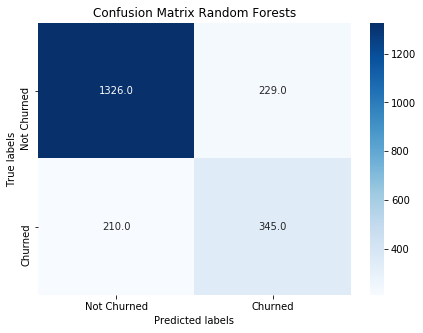

In [13]:
import seaborn as sns

#plotting a confusion matrix
labels = ['Not Churned', 'Churned']
plt.figure(figsize=(7,5))
ax= plt.subplot()
sns.heatmap(confusion_matrix_forest,cmap="Blues",annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Random Forests'); 

**Printing the Classification Report**

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rfc)) 

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1555
           1       0.60      0.62      0.61       555

   micro avg       0.79      0.79      0.79      2110
   macro avg       0.73      0.74      0.73      2110
weighted avg       0.79      0.79      0.79      2110



**Calculating Area Under the Curve**

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

y_pred_rfc=rfc_best.predict(X_test)
y_score_rfc = rfc_best.predict_proba(X_test)[:,1]
fpr, tpr,_ = roc_curve(y_test, y_score_rfc)
roc_auc_forests = auc(fpr, tpr)
print(roc_auc_forests)



0.8377202282668521


**LOGISTIC REGRESSION (Final Model)** 

It’s clear that false negatives are substantially more costly than false positives **(Discussed Under Cost Evaluation)**.Out of all the models tested,Logistic regression has the highest recall for class 1 (Customers Churned) and least numnber of false negatives.So I selected Logistic regression as my final model.

**Using Gridsearch to find the best parameters**

In [20]:
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

**More efficient parameter tuning using GridSearchCV**

In [11]:
from sklearn.model_selection import GridSearchCV
# Setup the hyperparameter grid
c_space = np.logspace(-3,6, 12)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)

# Fit it to the data
best_model = logreg_cv.fit(X_train_res, y_train_res)

#examine the best model
print(best_model.best_score_)
print(best_model.best_params_)
print(best_model.best_estimator_)

0.7800720620842572
{'C': 12.32846739442066}
LogisticRegression(C=12.32846739442066, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


**Fitting Logistic Regression with best parameters**

In [16]:
best_lr1 = LogisticRegression(C=0.8)
best_lr1.fit(X_train_res, y_train_res)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
from sklearn.metrics import confusion_matrix
y_pred_log = best_lr1.predict(X_test)
confusion_matrix_log = confusion_matrix(y_test, y_pred_log)
print(confusion_matrix_log)

[[1157  398]
 [ 116  439]]


**Printiong the Classification Report**

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_log)) 

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1555
           1       0.52      0.79      0.63       555

   micro avg       0.76      0.76      0.76      2110
   macro avg       0.72      0.77      0.72      2110
weighted avg       0.81      0.76      0.77      2110



**Plotting the Confusion Matrix**

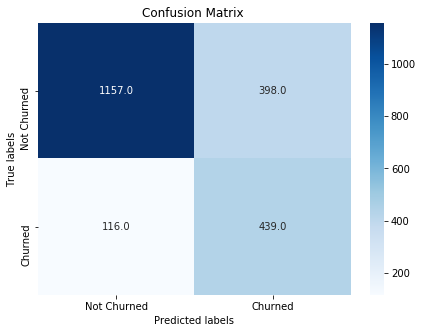

In [18]:
import seaborn as sns
labels = ['Not Churned', 'Churned']

plt.figure(figsize=(7,5))
ax= plt.subplot()
sns.heatmap(confusion_matrix_log,cmap="Blues",annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix ');


In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

y_pred_log=best_lr1.predict(X_test)
y_score_log = best_lr1.predict_proba(X_test)[:,1]
fpr, tpr,_ = roc_curve(y_test, y_score_log)
roc_auc_log = auc(fpr, tpr)
print(roc_auc_log)

0.8358042930390198


**AUC Curves for Logiostic Regression**

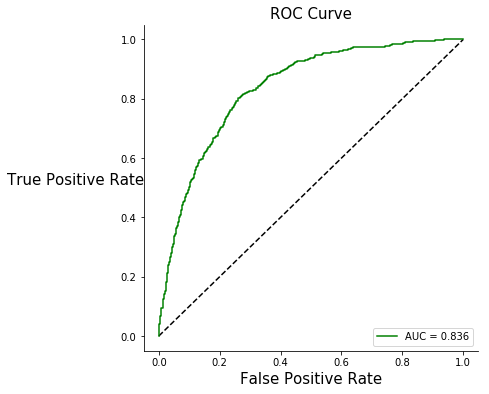

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from seaborn import despine

logit_roc_auc = roc_auc_score(y_test, best_lr1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_lr1.predict_proba(X_test)[:,1])

roc_auc = auc(fpr,tpr)

plt.figure(figsize=(6,6))


# Plotting our Baseline..
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr,'g',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.title('ROC Curve',fontsize = 15)
plt.xlabel('False Positive Rate',fontsize = 15)
plt.ylabel('True Positive Rate',rotation=0,labelpad=45,fontsize = 15)
despine()

**Optimal Threshold**

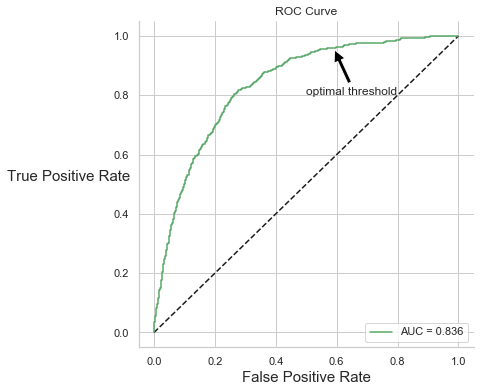

In [124]:
logit_roc_auc = roc_auc_score(y_test, best_lr1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_lr1.predict_proba(X_test)[:,1])

roc_auc = auc(fpr,tpr)

plt.figure(figsize=(6,6))


# Plotting our Baseline..
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, 'g',label='AUC = %0.3f'% roc_auc)
plt.annotate('optimal threshold', xy=(0.59, 0.96), xytext=(0.5, 0.8),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate',fontsize = 15)
plt.ylabel('True Positive Rate',rotation=0,labelpad=45,fontsize = 15)
despine()

**SVM MODELS**

**rbf kernel**

In [59]:
# Finding best parameters for rbf kernel.
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(X_train_res,y_train_res,5)

{'C': 10, 'gamma': 0.001}

In [61]:
model_svm2 = svm.SVC(kernel='rbf', gamma = 0.001) #Gamma is the free parameter of the Gaussian radial basis function.
model_svm2.fit(X_train_res, y_train_res)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [63]:
# predict out of sample
y_pred1 = model_svm2.predict(X_test)

In [65]:
cm_svm_rbf=confusion_matrix(y_test,y_pred1)
print(cm_svm_rbf)

[[1403  152]
 [ 409  146]]


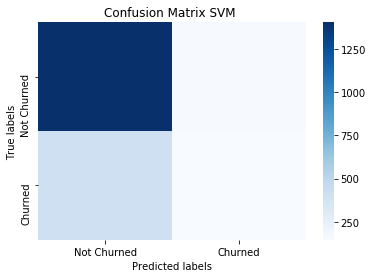

In [66]:
labels = ['Not Churned', 'Churned']
ax= plt.subplot()
sns.heatmap(cm_svm_rbf,cmap="Blues", ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix SVM ');

**Linear Kernel**

In [ ]:
# Finding best parameters for linear kernel.
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(X_train_res,y_train_res,5)

In [ ]:
model_svm1 = svm.SVC(kernel='linear', gamma = 0.001) #Gamma is the free parameter of the Gaussian radial basis function.
model_svm1.fit(X_train_res, y_train_res)

In [ ]:
# predict out of sample
y_pred1 = model_svm2.predict(X_test)

In [ ]:
cm_svm_linear=confusion_matrix(y_test,y_pred1)
print(cm_svm_linear)

In [ ]:
labels = ['Not Churned', 'Churned']
ax= plt.subplot()
sns.heatmap(cm_svm_rbf,cmap="Blues", ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix SVM (linear) ');

**KNN  MODEL**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
# define the parameter values that should be searched
k_range = list(range(1, 100))

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# scalarizing X_train and X_test
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

#fit the grid
grid.fit(X_train, y_train)

/Users/shwetapai/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/shwetapai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/Users/shwetapai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
/Users/shwetapai/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/shwetapai/

In [48]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7913449817147501
{'n_neighbors': 79}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=79, p=2,
           weights='uniform')


In [22]:
# train your model using all data and the best known parameters
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn = KNeighborsClassifier(n_neighbors=79, weights='uniform')
knn.fit(X_train, y_train)

# make a prediction on out-of-sample data
y_pred_knn=knn.predict(X_test)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix  
cm_knn=confusion_matrix(y_test, y_pred_knn)
print(cm_knn)

[[1515   40]
 [ 525   30]]


**Printing the Classification Report**

In [24]:
print(classification_report(y_test, y_pred_knn)) 

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1555
           1       0.43      0.05      0.10       555

   micro avg       0.73      0.73      0.73      2110
   macro avg       0.59      0.51      0.47      2110
weighted avg       0.66      0.73      0.65      2110



**Area Under Curve**

In [25]:
y_pred_knn=knn.predict(X_test)
y_score_knn = knn.predict_proba(X_test)[:,1]
fpr, tpr,_ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr, tpr)
print(roc_auc_knn)

0.6483861997045278


**Plotting the Confusion Matrix**

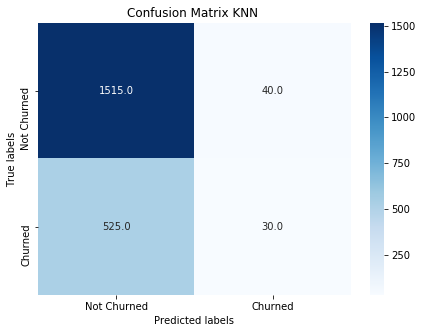

In [26]:
labels = ['Not Churned', 'Churned']
plt.figure(figsize=(7,5))
ax= plt.subplot()
sns.heatmap(cm_knn,cmap="Blues",annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix KNN ');

**ROC CURVES OF ALL MODELS TRIED**

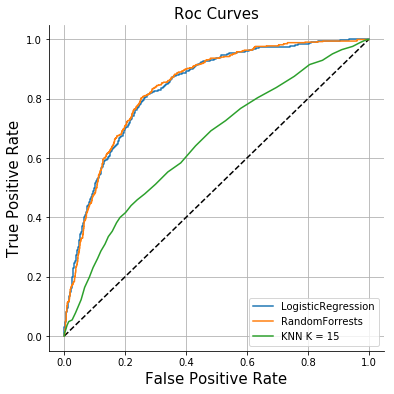

In [44]:
lr_score=best_lr1.predict_proba(X_test)[:,1]
rfc_score = rfc_best.predict_proba(X_test)[:,1]
#svm_score = model_svm1.predict_proba(xtest)[:,1]
knn_score = knn.predict_proba(X_test)[:,1]

#l_svm_score = l_svm.predict_proba(xtest)[:,1]

lr_fpr, lr_tpr,_ = roc_curve(y_test, lr_score)
rfc_fpr, rfc_tpr,_ = roc_curve(y_test, rfc_score)
#svm_fpr, svm_tpr,_ = roc_curve(ytest, svm_score)
knn_fpr, knn_tpr,_ = roc_curve(y_test, knn_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6,6))
plt.subplot(1,1,1)
# Plotting our Baseline..
plt.plot([0,1],[0,1], 'k--')

plt.plot(lr_fpr,lr_tpr, label = 'LogisticRegression')
plt.plot(rfc_fpr,rfc_tpr, label = 'RandomForrests')
plt.plot(knn_fpr,knn_tpr, label = 'KNN K = 15')
#plt.plot(l_svm_fpr,l_svm_tpr, label = 'SVM-Linear')

plt.legend()
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize = '15')
plt.ylabel('True Positive Rate', fontsize = '15')
plt.title('Roc Curves', fontsize = '15')
despine()

plt.savefig('RocCurve')


**CALCULATING OPTIMAL THRESHOLD**

**Including Cost**

In [98]:
def makecost(obs,prob,falsepos_cost,falseneg_cost,truepos_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        tpos=pred*obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost+ tpos*truepos_cost)
    return np.vectorize(cost)

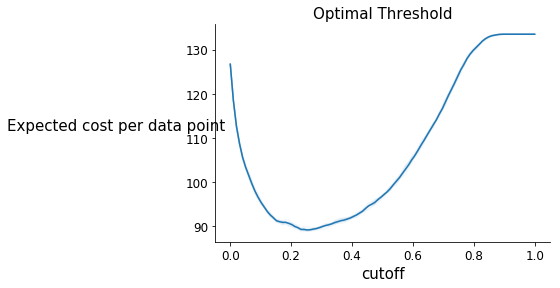

In [100]:
cut = np.linspace(0,1,100)
cost = np.zeros_like(cut)
from sklearn.model_selection import KFold, cross_val_predict
obs = np.ravel(y_train)

K = 10
for j in range(K):
    folds = KFold(n_splits=5,shuffle=True)
    prob = cross_val_predict(best_lr1,X_train,obs,cv=folds,method='predict_proba',n_jobs=5)[:,1]
    getcost = makecost(obs,prob,falsepos_cost=100,falseneg_cost=500,truepos_cost=200)
    currentcost = getcost(cut)/X_train.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost,c='C0',alpha=0.05)
cost /= K

plt.plot(cut,cost,c='C0')
plt.xlabel('cutoff',fontsize = 15)
plt.ylabel('Expected cost per data point',labelpad=69,fontsize = 15,rotation=0)
plt.title("Optimal Threshold",fontsize=15)
despine()

In [38]:
bestcut = cut[np.argmin(cost)]
bestcut

0.5252525252525253

In [39]:
min(cost)

97.24705404307194

**Finding the tpr and fpr for the optimal threshold**

In [40]:

pd.set_option('display.max_rows', 500)
cutoff_list = pd.DataFrame(np.column_stack([tpr, fpr, thresholds]), 
                               columns=['tpr', 'fpr', 'thresholds'])
cutoff_list

,tpr,fpr,thresholds
0,0.000000,0.000000,1.959530
1,0.001802,0.000000,0.959530
2,0.005405,0.000000,0.956639
3,0.005405,0.000643,0.955891
4,0.030631,0.000643,0.933292
5,0.030631,0.001286,0.932935
6,0.034234,0.001286,0.932238
7,0.034234,0.001929,0.932025
8,0.041441,0.001929,0.930502
9,0.041441,0.002572,0.929566


**Finding the Optimal Threshold without including cost**

In [45]:
# print the first 10 predicted probabilities of class membership
best_lr1.predict_proba(X_test)[0:10]

array([[0.50760687, 0.49239313],
       [0.72531979, 0.27468021],
       [0.67731542, 0.32268458],
       [0.14122484, 0.85877516],
       [0.06820993, 0.93179007],
       [0.48411235, 0.51588765],
       [0.3130812 , 0.6869188 ],
       [0.13115414, 0.86884586],
       [0.59768326, 0.40231674],
       [0.33986002, 0.66013998]])

**Row: observation**

Each row, numbers sum to 1

**Column: class**

2 response classes there 2 columns

column 0: predicted probability that each observation is a member of class 0
column 1: predicted probability that each observation is a member of class 1

**Importance of predicted probabilities**

We can rank observations by probability of a customer churning

Prioritize contacting those with a higher probability

**There is a 0.5 classification threshold**

Class 1 is predicted if probability > 0.5

Class 0 is predicted if probability < 0.5

In [46]:
# store the predicted probabilities for class 1 (ie customer will churn)
y_pred_prob = best_lr1.predict_proba(X_test)[:, 1]

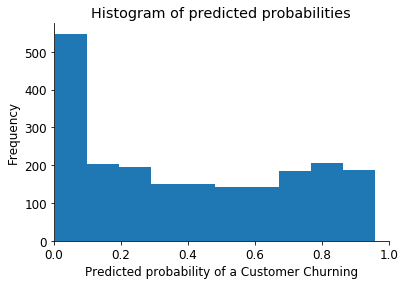

In [49]:
#Plot predicted probablities for class1
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12
plt.hist(y_pred_prob)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of a Customer Churning')
plt.ylabel('Frequency')
despine()

**Observation**

1.Most of observations have probability from between 0.1 and 0.2

2.Small number of observations with probability > 0.5

3.Most would be predicted "no churners" in this case

**Solution**

1.Decrease the threshold for predicting churners

2.Increase the sensitivity of the classifier

3.This would increase the number of TP

4.More sensitive to customers who churn

In [94]:
# predict churners if the predicted probability is greater than 0.2
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.2 and 0 otherwise
y_pred_class = binarize([y_pred_prob], 0.4)[0]

In [95]:
y_pred_prob

array([0.49239313, 0.27468021, 0.32268458, ..., 0.61171431, 0.00877243,
       0.00474428])

In [96]:
y_pred_class[0:10]

array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1.])

**Confusion Matrix with Optimal Threshold**

In [97]:
from sklearn.metrics import classification_report, confusion_matrix  
cm_optimal_threshold=confusion_matrix(y_test, y_pred_class)
print(cm_optimal_threshold)

[[1036  519]
 [  86  469]]


In [75]:
y_pred_log = best_lr1.predict(X_test)
confusion_matrix_log = confusion_matrix(y_test, y_pred_log)
print(confusion_matrix_log)

[[1157  398]
 [ 116  439]]


**COST EVALUATION**

There are costs associated with the model erroneously assigning false positives and false negatives. It is also important to look at similar costs associated with correct predictions of true positives and true negatives. Because the choice of the threshold affects all four of these statistics,it is important to consider the relative costs to the business for each of these four outcomes for each prediction.

What are the costs for my problem of customer churn?I will make some assumptions here.

**1.** I will assign the **true negatives** the cost of **USD 0**. My model essentially correctly identified a happy customer in this case, and I don’t need to do anything.

**2.** **False negatives** are the most problematic, because they incorrectly predict that a churning customer will stay. I will lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this post, I will assume **USD 500**. This is the cost of false negatives.

**3.** Finally, for customers that my model identifies as churning, I will assume a retention incentive in the amount of **USD 100**.This is the cost of both true positive and false positive outcomes.In the case of false positives (the customer is happy,but the model mistakenly predicted churn),I will “waste” the USD 100 concession.

**It’s clear that false negatives are substantially more costly than false positives**. Instead of optimizing for total error, I should be minimizing a cost function that looks like this:

500∗FN(C)+0TN(C) + 100∗FP(C)+100TP(C)

C:Count

In [41]:
no_churn = (y_test['Churn'] == 0).sum()
yes_churn=(y_test['Churn'] == 1).sum()
print("Not Churned:",no_churn)
print("Yes Churned:",yes_churn)

Not Churned: 1555
Yes Churned: 555


**Worst Case Scenario** 

I don't apply any model to predict churn and assume that no customer will churn.But in reality, 555 customers ended up churning.So to maintain my customer base, I would have to spend ($500*555) USD 277,500 .

**Best Case Scenario**

I have a model that correctly predicts who all will churn and to maintain the customer base, give them concessions ($100).So I would have to spend (555*100) USD 55500

**Model Predictions**
The models identifies, FN, and TP.So to maintain the current customer base, I would have to spend (116* 500)+(837* 100)=141700.So using a model will save  USD 135,800 in a month.


**Focussing retention efforts on all customers**
I don't apply any model and decide to focus rention efforts on all customers.So I give USD 100 worth of discounts to everyone.I would have to spend (100 * 2110)=211,000.So compared to focusing retention efforts on everyone, implementing the current model would save USD 69300.

**Graphs Depicting Different Scenarios**

In [6]:
list_scenarios=['No Model','Discounts to All','Logistic Model','Ideal Model']
list_cost=[277500,211000,141700,55500]
df_list = pd.DataFrame(
    {'Scenario': list_scenarios,
     'Cost': list_cost
    })

In [7]:
df_list

,Scenario,Cost
0,No Model,277500
1,Discounts to All,211000
2,Logistic Model,141700
3,Ideal Model,55500


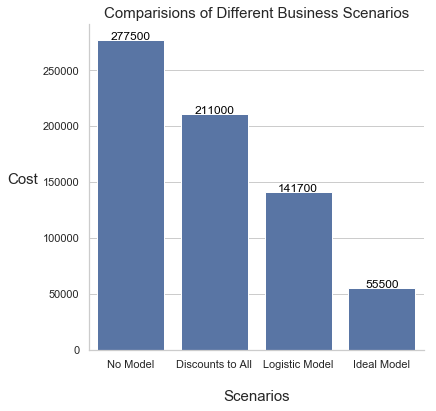

In [9]:
from seaborn import despine

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
fig=sns.barplot(x="Scenario", y="Cost", data=df_list,
            label="Comparision of Business cASES", color="b")
for index, row in df_list.iterrows():
    fig.text(row.name,row.Cost, round(row.Cost,2), color='black', ha="center")
plt.xlabel("Scenarios",fontsize=15,labelpad=20)
plt.ylabel("Cost",rotation=0,labelpad=20,fontsize=15)
plt.title("Comparisions of Different Business Scenarios",fontsize=15)
despine()